In [2]:
import sys
sys.path.append('../')

import glob

from typing import Tuple, Union, List
import pandas as pd
import numpy as np
import networkx as nx
from tqdm.notebook import tqdm as tqdm

from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from hyperopt.pyll import scope
from hyperopt.pyll.stochastic import sample as ho_sample

import torch
import torch.nn as nn

import torch_geometric as pyg
from torch_geometric.utils.convert import from_networkx

from src.utils import *
from dataset import *
from src.train import train, test
from src.dataloaders import make_dataloaders_from_dataset
from src.model import KnnEstimator

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

from IPython.display import clear_output

%matplotlib inline
%load_ext autoreload
%autoreload 2

device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')

In [3]:
G = nx.readwrite.read_gpickle('data/network32.gpickle')

In [4]:
# Pytorch geometric Data object. For now used only for storing node embedding. 
# Supposed to be used in the future for obtaining node embeddings.
pyg_graph = from_networkx(G, group_node_attrs=['embedding'])
pyg_graph.to(device)

/home/eldervald/miniconda3/envs/traffic/lib/python3.7/site-packages/torch_geometric/utils/convert.py:178: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1646755953518/work/torch/csrc/utils/tensor_new.cpp:210.)
  data[key] = torch.tensor(value)


Data(edge_index=[2, 442], id=[233], lat=[233], lon=[233], index_right=[233], population=[233], jobs=[233], labor_force_rate=[233], housing_sales_num_Total:=[233], housing_sales_num_Total:!!Less than $10,000=[233], housing_sales_num_Total:!!$10,000 to $14,999=[233], housing_sales_num_Total:!!$15,000 to $19,999=[233], housing_sales_num_Total:!!$20,000 to $24,999=[233], housing_sales_num_Total:!!$25,000 to $29,999=[233], housing_sales_num_Total:!!$30,000 to $34,999=[233], housing_sales_num_Total:!!$35,000 to $39,999=[233], housing_sales_num_Total:!!$40,000 to $49,999=[233], housing_sales_num_Total:!!$50,000 to $59,999=[233], housing_sales_num_Total:!!$60,000 to $69,999=[233], housing_sales_num_Total:!!$70,000 to $79,999=[233], housing_sales_num_Total:!!$80,000 to $89,999=[233], housing_sales_num_Total:!!$90,000 to $99,999=[233], housing_sales_num_Total:!!$100,000 to $124,999=[233], housing_sales_num_Total:!!$125,000 to $149,999=[233], housing_sales_num_Total:!!$150,000 to $174,999=[233], 

In [5]:
def weight_fn(dists, lamb):
    return torch.exp(-lamb * dists) + 1e-7


class Scaler(nn.Module):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
    
    def forward(self, X, neighbors):
        # print(X.shape, neighbors.shape)
        return X[:, None] / neighbors


class Estimator(KnnEstimator):
    def __init__(self, pyg_graph: pyg.data.Data, obs_nodes, obs_targets, neighbors_num=20, lambda_1=None) -> None:
        super().__init__(pyg_graph, obs_nodes, obs_targets, neighbors_num)

        # self.k = torch.tensor([1.0]).to(device)
        self.scaler = Scaler()

        if lambda_1 is not None:
            self.lambda_1 = lambda_1
        else:
            self.lambda_1 = nn.Parameter(torch.rand(1))

    def forward(self, X):
        # getting nearest observed nodes
        X_indices = torch.as_tensor(self.node_to_idx(X))
        dists, neighbors_indices, targets = self.get_kneighbors_with_observations(X_indices)
        dists = dists.to(device)
        neighbors_indices = torch.as_tensor(neighbors_indices)
        targets = targets.to(device)

        dist_weights = weight_fn(dists, self.lambda_1)

        # sum normalizization
        dist_weights = nn.functional.normalize(dist_weights, p=1)
        att_weights = dist_weights

        X_scale = self.g.mean_target[X_indices]
        neighbors_scales = self.g.mean_target[neighbors_indices]

        # print(self.scaler(X_population, neighbors_population))
        scaled_targets = targets * self.scaler(X_scale, neighbors_scales)

        # interpolation 
        result = torch.sum(att_weights.mul(scaled_targets), dim=-1)
        # print(att_weights[0])
        # fuck()

        return result

In [6]:
hp_space = {
    'lambda_1': hp.loguniform('lambda', low= -5 * np.log(10), high= 2 * np.log(10)),
    # 'neighbors_num': scope.int(hp.quniform('num_neighbors', low=3, high=100, q=5))
}

In [7]:
for path in tqdm(glob.glob('datasets/*')[:1]):
    day = path.split('/')[1].split('.')[0]
    print(day)

    try:
        ds = torch.load(path)
    except:
        print('Cannot read')
        continue

    train_loader, val_loader, test_loader = make_dataloaders_from_dataset(ds, batch_size=64)
    train_batches = [batch for batch in train_loader]
    train_nodes = [n for batch in train_batches for n in batch[0]]
    train_targets = torch.cat([batch[1] for batch in train_batches])
    
    model = Estimator(pyg_graph, train_nodes, train_targets).to(device)

  0%|          | 0/1 [00:00<?, ?it/s]

2021-01-03


In [8]:
from sklearn.metrics import r2_score

trials = Trials()

def objective(params):
    model = Estimator(pyg_graph, train_nodes, train_targets, neighbors_num=50, **params)
    # model.eval()
    pred = []
    gt = []
    for x, y in test_loader:
        out = model(x)
        pred.extend(out.cpu())
        gt.extend(y)

    score = r2_score(gt, pred)
    return {'lambda': params['lambda_1'], 'loss': -score, 'status': STATUS_OK}

best_params = fmin(objective, hp_space, algo=tpe.suggest, max_evals=50, trials=trials)

100%|██████████| 50/50 [00:00<00:00, 122.51trial/s, best loss: -0.7689312314787895]


In [9]:
pd.DataFrame(trials.results).sort_values('loss')

,lambda,loss,status
26,0.005914,-0.768931,ok
34,0.006950,-0.768915,ok
43,0.007682,-0.768628,ok
24,0.004742,-0.768369,ok
36,0.008365,-0.768164,ok
31,0.003927,-0.767605,ok
28,0.003311,-0.766822,ok
0,0.010124,-0.766169,ok
1,0.002296,-0.765148,ok
21,0.002183,-0.764932,ok


$$T(a) = s(a)\sum_{b \neq a,\space b\subset Train } \frac{T(b)}{s(b)}w(a, b), \textrm{where summation is calculated for the {\bf k} nearest neighbors.}$$

$$ w(a,b)= \frac{u(a,b)}{\sum_{b \neq a} u(a, b)};$$

$u(a, b) = exp(-\lambda_1 d(a, b));$

$s(a)$ - mean target of location $a$

So for this model $\lambda_1$ is optimized.

In [9]:
class RMSELoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.mse = nn.MSELoss()
        
    def forward(self, pred, y):
        return torch.sqrt(self.mse(pred, y))

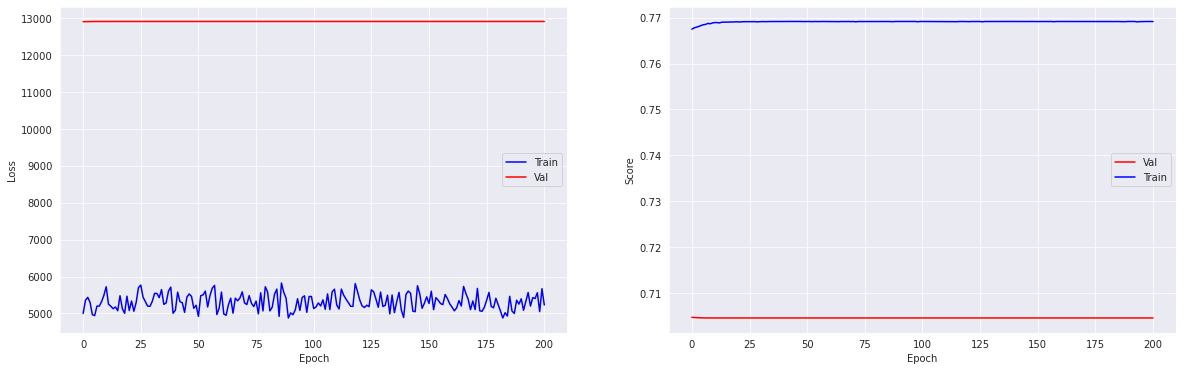

tensor([0.1936, 0.1641, 0.1605, 0.1102, 0.0942, 0.0245, 0.0242, 0.0241, 0.0236,
        0.0208, 0.0182, 0.0181, 0.0180, 0.0167, 0.0164, 0.0161, 0.0161, 0.0138,
        0.0136, 0.0130])
tensor([0.0827, 0.0719, 0.0675, 0.0630, 0.0570, 0.0551, 0.0533, 0.0514, 0.0496,
        0.0472, 0.0458, 0.0432, 0.0427, 0.0417, 0.0408, 0.0388, 0.0380, 0.0378,
        0.0363, 0.0360])
lambda_1 Parameter containing:
tensor([0.2274], requires_grad=True)
2021-01-03, Test loss: 3561.5010, test score: 0.7863


In [10]:
results = dict()
loss_fn = nn.MSELoss().to(device)
model = None

for path in tqdm(glob.glob('datasets/*')[:20]):
    day = path.split('/')[1].split('.')[0]
    print(day)

    try:
        ds = torch.load(path)
    except:
        continue

    train_loader, val_loader, test_loader = make_dataloaders_from_dataset(ds, batch_size=64)
    train_batches = [batch for batch in train_loader]
    train_nodes = [n for batch in train_batches for n in batch[0]]
    train_targets = torch.cat([batch[1] for batch in train_batches])
    
    if model is None:
        model = Estimator(pyg_graph, train_nodes, train_targets).to(device)
    else:
        model.set_observations(train_nodes, train_targets)
        
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)
    # scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 20, gamma=0.9)

    best_model = train(model, train_loader, val_loader, loss_fn, optimizer, device, num_epochs=200, plot=True)
    test_loss, test_score = test(best_model, test_loader, loss_fn, device)

    for name, param in best_model.named_parameters():
        print(name, param)

    results[f'{day}'] = test_score 
    print(f'{day}, Test loss: {test_loss:.4f}, test score: {test_score:.4f}')
    break

In [51]:
def weight_fn(dists, lamb):
    return torch.exp(-lamb * dists) + 1e-7


class Scaler(nn.Module):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
    
    def forward(self, X, neighbors):
        # print(X.shape, neighbors.shape)
        return X[:, None] / neighbors


class Attention(nn.Module):
    def __init__(self, in_channels, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.in_channels = in_channels
        self.lin = nn.Linear(self.in_channels, 1)
        self.activation = nn.LeakyReLU(0.2)
    
    def forward(self, X, neighbors):
        # X[:, None].expand(-1, neighbors.shape[1], -1)
        # neighbors = neighbors.reshape(X.shape[0], -1)
        in_channels = X.shape[-1]
        batch_size = X.shape[0]

        out = X[:, None].expand(-1, neighbors.shape[1], -1) + neighbors
        out = self.lin(out.reshape(-1, in_channels)).reshape(batch_size, -1)
        out = self.activation(out)
        out = torch.softmax(out, dim=-1)
    
        return out



class Estimator(KnnEstimator):
    def __init__(self, pyg_graph: pyg.data.Data, obs_nodes, obs_targets, neighbors_num=20, lambda_1=None) -> None:
        super().__init__(pyg_graph, obs_nodes, obs_targets, neighbors_num)

        # self.k = torch.tensor([1.0]).to(device)
        self.scaler = Scaler()
        self.attention = Attention(32)

        if lambda_1 is not None:
            self.lambda_1 = lambda_1
        else:
            self.lambda_1 = nn.Parameter(torch.rand(1))
        
        self.out_channels = 16
        self.lin = nn.Linear(32, self.out_channels)



    def forward(self, X):
        # getting nearest observed nodes
        X_indices = torch.as_tensor(self.node_to_idx(X))
        dists, neighbors_indices, targets = self.get_kneighbors_with_observations(X_indices)
        dists = dists.to(device)
        neighbors_indices = torch.as_tensor(neighbors_indices)
        targets = targets.to(device)

        # dist_weights = weight_fn(dists, self.lambda_1)

        # sum normalizization
        # dist_weights = nn.functional.normalize(dist_weights, p=1)
        # att_weights = dist_weights

        X_scale = self.g.mean_target[X_indices]
        neighbors_scales = self.g.mean_target[neighbors_indices]
        X_emb = self.g.x[X_indices]
        neighbors_emb = self.g.x[neighbors_indices]

        # print(self.scaler(X_population, neighbors_population))
        scaled_targets = targets * self.scaler(X_scale, neighbors_scales)

        att_weights = self.attention(X_emb, neighbors_emb)

        # interpolation 
        result = torch.sum(att_weights.mul(scaled_targets), dim=-1)

        return result

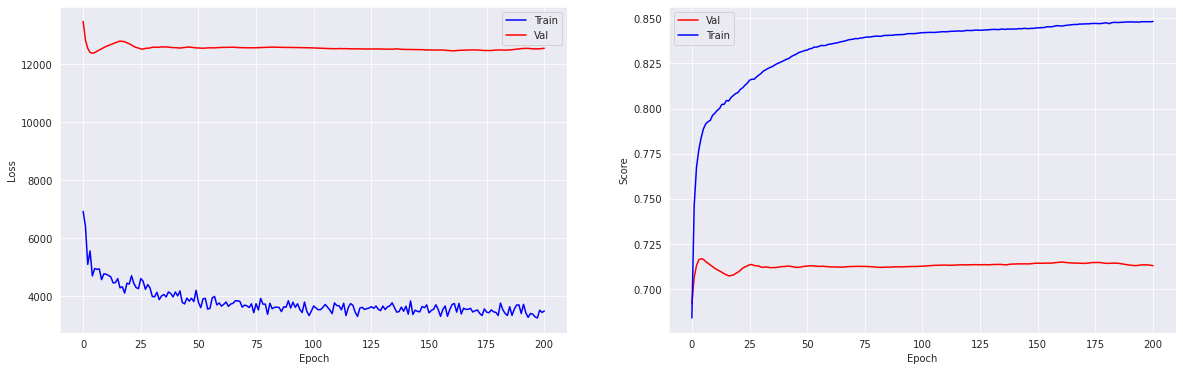

lambda_1 Parameter containing:
tensor([0.0491], requires_grad=True)
attention.lin.weight Parameter containing:
tensor([[-0.1399, -0.1216,  0.1123, -0.1203,  0.0945,  0.2108,  0.1018, -0.0523,
         -0.0093, -0.0470, -0.0439,  0.1194, -0.1021, -0.0974, -0.0253, -0.0387,
         -0.1146, -0.0650,  0.0489, -0.1022,  0.1000,  0.0045, -0.0929,  0.1542,
          0.0928,  0.1247, -0.0851,  0.1052, -0.1795,  0.0762, -0.0756,  0.0727]],
       requires_grad=True)
attention.lin.bias Parameter containing:
tensor([0.0105], requires_grad=True)
lin.weight Parameter containing:
tensor([[ 1.2540e-01,  9.4202e-02,  6.2086e-02, -8.8062e-02,  3.3383e-02,
         -7.4590e-02, -1.3224e-01,  7.9472e-02,  1.1438e-01, -3.0828e-02,
          1.5789e-01, -1.2412e-01, -3.3954e-02, -7.6017e-02, -1.4711e-01,
          1.5902e-03,  9.5493e-02, -1.0165e-01,  5.3926e-03,  4.5463e-03,
          4.9160e-02, -1.3668e-01, -3.7341e-03, -1.2196e-01,  6.4713e-02,
         -9.3987e-02, -1.6767e-02,  1.1868e-01, -3.9703

In [52]:
results = dict()
loss_fn = nn.MSELoss().to(device)
model = None

for path in tqdm(glob.glob('datasets/*')[:20]):
    day = path.split('/')[1].split('.')[0]
    print(day)

    try:
        ds = torch.load(path)
    except:
        continue

    train_loader, val_loader, test_loader = make_dataloaders_from_dataset(ds, batch_size=64)
    train_batches = [batch for batch in train_loader]
    train_nodes = [n for batch in train_batches for n in batch[0]]
    train_targets = torch.cat([batch[1] for batch in train_batches])
    
    if model is None:
        model = Estimator(pyg_graph, train_nodes, train_targets).to(device)
    else:
        model.set_observations(train_nodes, train_targets)
        
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)
    # scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 20, gamma=0.9)

    best_model = train(model, train_loader, val_loader, loss_fn, optimizer, device, num_epochs=200, plot=True)
    test_loss, test_score = test(best_model, test_loader, loss_fn, device)

    for name, param in best_model.named_parameters():
        print(name, param)

    results[f'{day}'] = test_score 
    print(f'{day}, Test loss: {test_loss:.4f}, test score: {test_score:.4f}')
    break